Module 5 Assignment Matt Klekar: Custom CNN for CelebA dataset.

Quick summary:

I have chosen the CelebA dataset from Kaggle (more details in code below). The objective of the model I am making is to accurately predict image attributes for a given image in the dataset. The attributes I have chosen are "Smiling", "Sunglasses", "Blond Hair", "Young", and "Male".

The Model I have chosen is inspired by ResNet and is similar to a MobileNetV2 CNN. It is similar to these two because it uses inverted bottlenecks and residucal connections. The main distinction between my model and these two is that mine utilizes Grouped Convolutions, instead of depthwise separable (like in MobileNetV2) and standard (as in ResNet).

To train this model, I used BCELogitsLoss as my loss function. This is similar to Cross Entropy, but is used for multi-label classification. Cross Entropy cannot be used for multi-label classifications. Then, I used an SGD optimizer, as we have a larger dataset. This model takes a while to train. When running training and logging loss per epoch, this section of code will take about 25-30 minutes.

Importing essential libraries

In [1]:
import os
import random
import time
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data import random_split
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
##Setting random seeds. Creates random module.
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cuda


Importing Dataset.

The dataset I am using comes from Kaggle. It is the celebrity face recognition image classification dataset. It is by Jessica Li. For this, our objective will be to identify different attributes about the individual in each image (i.e, smiling/winking/blinking/etc).  If you want to view the dataset and its respective files, use this link : https://www.kaggle.com/datasets/jessicali9530/celeba-dataset?resource=download.





In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'celeba-dataset' dataset.
Path to dataset files: /kaggle/input/celeba-dataset


The below code in this chunk is from the Kaggle discussion board post related to the dataset, posted by Ali Abdollahi. This helps with the splitting of the CelebA dataset. It normalizes the images to [0,1] and distinguishes the image files and the attribute file. It also focuses on 5 of the 40 attributes to speed up training. Source: https://www.kaggle.com/code/aabdollahii/multi-task-learning-mtl-tutorial

In [4]:
# Define paths
BASE_PATH = "/kaggle/input/celeba-dataset/"
IMAGE_PATH = os.path.join(BASE_PATH, "img_align_celeba", "img_align_celeba")
ATTRIBUTE_PATH = os.path.join(BASE_PATH, "list_attr_celeba.csv")


# Load attributes
df_attr = pd.read_csv(ATTRIBUTE_PATH)
for col in df_attr.columns:
 if col != 'image_id':
        df_attr[col] = df_attr[col].replace(-1, 0)
# Select our target attributes for the multi-task problem
TARGET_ATTRIBUTES = ['Smiling', 'Eyeglasses', 'Male', 'Blond_Hair', 'Young']

# Create a new DataFrame with only the image_id and our target attributes
df_final = df_attr[['image_id'] + TARGET_ATTRIBUTES].reset_index(drop=True)


train_df, test_val_df = train_test_split(df_final, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 162079
Validation set size: 20260
Test set size: 20260


Creating custom dataset class (also from source above, see URL):


In [5]:
# Create the custom dataset class
class CelebADataset(Dataset):
    def __init__(self, df, img_dir, attributes, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.attributes = attributes
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image_id'])

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Get labels
        labels = torch.FloatTensor(row[self.attributes].values.astype(float))

        return image, labels

Normalizing image data using ImageNet Mean and STD, and then creating train, test, and validation datasets.

In [6]:
CELEBA_MEAN = (0.485, 0.456, 0.406) ##Using standard mean and STD for Images
CELEBA_STD = (0.229, 0.224, 0.225)
batch_size = 64 # Reduced batch size
num_workers = 4

train_transform = transforms.Compose([
    transforms.Resize((64, 64)), # Reduced image size
    transforms.RandomCrop(64, padding=4), ##Batch size and padding around each image.
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), ##Normalizes to [0,1]
    transforms.Normalize(CELEBA_MEAN, CELEBA_STD)##Standardsizes to mean and STD of dataset.
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)), # Reduced image size
    transforms.ToTensor(),
    transforms.Normalize(CELEBA_MEAN, CELEBA_STD)
])

##Dataset does not come with a train,test split, so we will have to create one on our own.
import torchvision.datasets as datasets # Import the datasets module

# Instantiate datasets for each split
train_data = CelebADataset(train_df, IMAGE_PATH, TARGET_ATTRIBUTES, transform=train_transform)
val_data = CelebADataset(val_df, IMAGE_PATH, TARGET_ATTRIBUTES, transform=test_transform)
test_data= CelebADataset(test_df, IMAGE_PATH, TARGET_ATTRIBUTES, transform=test_transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory = True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory = True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Building blocks for Modified CNN.

In [7]:
class GroupConvBNReLU(nn.Sequential):
  ## Grouped convolution + batch norm +ReLU 6 Helper. This is a variant of the ResNet CNN algorithm.
    def __init__(self, in_planes=32, out_planes=64, kernel_size=3, stride=1, padding=1, groups=4): ##Using group = 6
      padding = (kernel_size-1)//2
      super().__init__(
          nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False),
          nn.BatchNorm2d(out_planes),
          nn.ReLU6(inplace=True)
      )

class GroupedResidual(nn.Module):
  ##Modified Grouped residual/bottleneck block
    def __init__(self, inp, outp, stride, expand_ratio):
      super().__init__()
      assert stride in [1,2]
      self.stride = stride
      hidden_dim = int(round(inp*expand_ratio))
      self.use_residual = self.stride == 1 and inp == outp
      layers = []
      ##applying simple 1x1 convolution. NO grouping yet.
      if expand_ratio != 1:
        layers.append(GroupConvBNReLU(inp, hidden_dim, kernel_size=1, stride = 1, padding = 0))
      ##3x3 groupwise convolution after 1x1 convolution:
      layers.append(GroupConvBNReLU(hidden_dim, hidden_dim,
                                  kernel_size=3, stride=stride,
                                  padding=1, groups=4)) ##Groups !=hidden dim here; major component of grouped convolution.
      ##Need to apply linear projection. 1x1.
      layers.append(nn.Conv2d(hidden_dim, outp, kernel_size=1, stride=1, padding=0, bias=False))
      layers.append(nn.BatchNorm2d(outp))
      self.conv = nn.Sequential(*layers)

    def forward(self, x):
      if self.use_residual:
        return x + self.conv(x)
      else:
        return self.conv(x)

Modified ResNet/MobileNetV2 Construction. The below setup is a mix between ResNet and MobileNetV2 CNNs. It uses grouped convolution instead of depthwise separable, like MobileNet would. This also differs from ResNet because ResNet uses standard convolutions.

In [8]:
class ModifiedRes(nn.Module):
    def __init__(self, num_classes =40, width_multiplier=1, round_nearest =8, first_conv_stride=1): ## num_classes = 40 classes in attribute classification.
        super().__init__()
        ##grouped resid setting = [inp, out, stride, exp ratio, repeats]
        grouped_residual_setting = [
            [32,16,1,1,1], ##[inp = 32, out=16, stride = 1, exp ratio = 1, repeat = 1]
            [16,24,2,6,2],
            [24,32,2,6,3],
            [32,64,2,6,4],
            [64,96,1,6,5],
            [96,160,2,6,6],
            [160,320,1,6,7]
        ]
        input_channel = 32
        last_channel = 1280

        def _make_divisible(v, divisor = round_nearest, min_value=None):
            if min_value is None:
                min_value = divisor
            new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
            if new_v < 0.9 * v:
                new_v += divisor
            return new_v
        ## Adjusting Channels by width multiplier.
        input_channel = _make_divisible(input_channel * width_multiplier)
        last_channel = _make_divisible(last_channel * max(1.0, width_multiplier))

        ##Building first layer. Keeping stride =1
        features = [GroupConvBNReLU(3, input_channel, stride=first_conv_stride, groups=1)] ## Set groups to 1

        ## Building residual blocks, but with the grouping that we set in place in the previous cell.
        for inp, out, stride, expand_ratio, repeats in grouped_residual_setting:
            output_channel = _make_divisible(out * width_multiplier)
            for i in range(repeats):
                stride = stride if i == 0 else 1
                features.append(GroupedResidual(input_channel, output_channel, stride, expand_ratio))
                input_channel = output_channel

        ## Final layers
        features.append(GroupConvBNReLU(input_channel, last_channel, kernel_size=1))
        self.features = nn.Sequential(*features)

        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(last_channel, num_classes)
        )

        ##initializing weights:

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x=F.adaptive_avg_pool2d(x, (1,1)) ## For global average pooling.
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

Model/parameter/output shape tests.


In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

##Instantiate Model:
model=ModifiedRes(num_classes=len(TARGET_ATTRIBUTES), width_multiplier=1, first_conv_stride =1).to(device)
print("Model:", model.__class__.__name__)
print("Parameters:", count_parameters(model))

##DUMMY FORWARD WITH CELEBA Size Batch (Batch =8, 3x128x128)
x=torch.randn(4,3,128,128).to(device) # Reduced dummy batch size to 4
with torch.no_grad():
  out = model(x)
print("Output shape (batch x classes):", out.shape)
assert out.shape == (4, len(TARGET_ATTRIBUTES)), 'Unexpected output shape - check model implementation'

Model: ModifiedRes
Parameters: 74317349
Output shape (batch x classes): torch.Size([4, 5])


PART 5: TRAINING. Since I am using BCELogitsLoss. This is a version of Cross Entropy Loss that deals with multi-label classification, which is what we are dealing with in this CelebA dataset.

In [10]:
def accuracy(outputs, targets, threshold = 0.5):
   ##Needed to compute accuracy scalar. Since this is a multi-layer classification problem , we need this accuracy function as opposed to a single layer accuracy function.
  probabilties = torch.sigmoid(outputs)
  predictions = (probabilties >= threshold).float()
  return (predictions == targets).float().mean().item()
def train_one_epoch(model, loader, optimizer, criterion, device): ##Setting up definition to train just one epoch.
  model.train()
  running_loss = 0.0 ##Tracking loss
  running_acc = 0.0 ##Tracking Accuracy
  total = 0
  for images, targets in loader:
    images, targets = images.to(device), targets.to(device)
    targets = targets.float()
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    batch_size = images.size(0)
    running_loss += loss.item() * batch_size
    running_acc += accuracy(outputs, targets) * batch_size
    total += batch_size

  epoch_loss = running_loss / total
  epoch_acc = running_acc / total
  return epoch_loss, epoch_acc

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    total = 0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        loss = criterion(outputs, targets)

        batch_size = images.size(0)
        running_loss += loss.item() * batch_size
        running_acc += accuracy(outputs, targets) * batch_size
        total += batch_size
    eval_loss = running_loss / total
    eval_acc = running_acc / total
    return eval_loss, eval_acc

Full Training Loop (Fit)

In [11]:
def fit (model, train_loader, test_loader, device, epochs = 10, lr = 0.1, weight_decay = 0.0001):
  model = model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = 0.9, weight_decay = weight_decay, nesterov = True)
  criterion = nn.BCEWithLogitsLoss() ##NEED TO USE LOGITS INSTEAD OF CROSS ENTROPY. WE ARE DEALING WITH MULTI-LAYER CLASSIFICATION
  scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1) #scheduler will run every 3 epochs, since epoch =10.

  ##Tracking loss per epoch:

  history = {'epoch': [], 'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': [], 'time': []}
  best_acc = 0.0
  best_path = 'ModifiedRes_celebA_best.pth'
  for epoch in range(1, epochs + 1 ):
    start = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    scheduler.step()

    dt = time.time() - start ##Tracking change in time between epochs.
    history['epoch'].append(epoch)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    history['time'].append(dt)

    print(f"Epoch{epoch:02d}/{epochs} - train_loss: {train_loss:.4f} acc: {100*train_acc:.2f}% | " +
          f"test_loss: {test_loss:.4f} acc: {100*test_acc:.2f}% | {dt:.1f}s")
    ##Saving the best model:
    if test_acc > best_acc:
      best_acc = test_acc
      torch.save(model.state_dict(), best_path)
      print(f"  -> Best Model Saved (acc: {100*test_acc:.2f}%).")
  return history, best_path

MODEL TRAINING:

This block of code will train our model and print out accuracy and loss per epoch.

In [12]:
##Fresh Model for training.

model = ModifiedRes(num_classes=len(TARGET_ATTRIBUTES), width_multiplier=1, first_conv_stride =1)

##Run training, can increase epochs for better accuracy:

history, best_path = fit(model, train_loader, test_loader, device, epochs = 10, lr = 0.05)

print('\nTraining finished. Best Checkpoint:', best_path)

Epoch01/10 - train_loss: 0.2642 acc: 88.59% | test_loss: 0.1983 acc: 91.89% | 342.5s
  -> Best Model Saved (acc: 91.89%).
Epoch02/10 - train_loss: 0.1857 acc: 92.33% | test_loss: 0.1718 acc: 93.04% | 165.4s
  -> Best Model Saved (acc: 93.04%).
Epoch03/10 - train_loss: 0.1643 acc: 93.30% | test_loss: 0.1545 acc: 93.66% | 167.2s
  -> Best Model Saved (acc: 93.66%).
Epoch04/10 - train_loss: 0.1406 acc: 94.28% | test_loss: 0.1360 acc: 94.39% | 165.6s
  -> Best Model Saved (acc: 94.39%).
Epoch05/10 - train_loss: 0.1364 acc: 94.45% | test_loss: 0.1352 acc: 94.43% | 165.5s
  -> Best Model Saved (acc: 94.43%).
Epoch06/10 - train_loss: 0.1340 acc: 94.53% | test_loss: 0.1332 acc: 94.53% | 165.8s
  -> Best Model Saved (acc: 94.53%).
Epoch07/10 - train_loss: 0.1308 acc: 94.67% | test_loss: 0.1313 acc: 94.59% | 166.8s
  -> Best Model Saved (acc: 94.59%).
Epoch08/10 - train_loss: 0.1302 acc: 94.70% | test_loss: 0.1306 acc: 94.63% | 167.5s
  -> Best Model Saved (acc: 94.63%).
Epoch09/10 - train_loss:

Training curves per Epoch

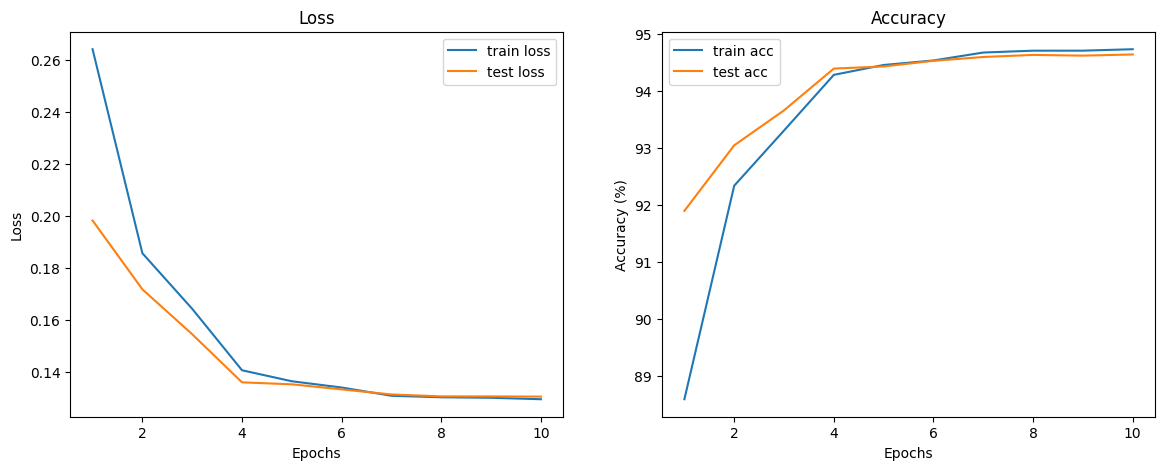

In [14]:
def plot_history(history):
  epochs = history['epoch']
  plt.figure(figsize = (14,5))
  plt.subplot(1,2,1)
  plt.plot(epochs, history['train_loss'], label = 'train loss')
  plt.plot(epochs, history['test_loss'], label = 'test loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Loss') # Added title

  plt.subplot(1,2,2)
  plt.plot(epochs, [100*x for x in history['train_acc']], label = 'train acc') # Corrected generator expression
  plt.plot(epochs, [100*x for x in history['test_acc']], label = 'test acc') # Corrected generator expression
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy (%)')
  plt.legend()
  plt.title('Accuracy')
  plt.show()

plot_history(history) # Moved outside the function definition

According to our above graphs, it looks like the model is learning well. There seems to be convergence around epochs 7 and 8. There does not seem to be a danger for overfitting. In addition, it seems like the dropout function is working, as test loss appears to be quite similar to training loss in the end. In addition, test loss becomes very low as the model converges, making this model quite useful for real world data.

Best Model checkpoint and Final Evaluation:

In [16]:
##Best Model checkpoint

best_model = ModifiedRes(num_classes=len(TARGET_ATTRIBUTES), width_multiplier=1, first_conv_stride =1)
best_model.load_state_dict(torch.load(best_path))
best_model.to(device) # Move the model to the device
crit = nn.BCEWithLogitsLoss() ##Need Logit Loss due to Multi-label classification.
test_loss, test_acc = evaluate(best_model, test_loader, crit, device)
print(f"Best Model - test_loss: {test_loss:.4f} acc: {100*test_acc:.2f}%")

Best Model - test_loss: 0.1305 acc: 94.64%


STRENGTHS/LIMITATIONS OF THIS MODEL:

With a final accuracy of 94.6%, this model does seem to fit the data pretty well. It took about 25 minutes to run the full training loop for just 10 epochs. However, in terms of strengths, replacing the depthwise separable convolutions from MobileNetV2 with my groupwise convolutions added some strengths to my model. To compare with MobileNetV2, the groupwise convolutions that I added (groups=4) is less extreme than the depthwise separable convolutions of MobileNet. This means that more cross-channel connections are preserved. In comparison with ResNet, ResNet uses full convolutions throughout the Network, which uses a lot of parameters. My model makes this more efficient by usign the bottleneck residual technique, as well as grouped convolutions. One large strength of my model is that one can use it for multi-label classification tasks, as ResNet and MobileNetV2 are designed for single-label classification tasks.

In terms of drawbacks of my model, I believe this would have slightly less accruacy then ResNet or MobileNetV2 models. These models come with a pre-trained database. In addition, my grouped convolutions in this custom model has less channel interaction than MobileNet or ResNet, so some accuracy points may be traded off here. In addition, because of the grouped convolutions and custom parameters (as-opposed to pre-trained in MobileNetV2 and ResNet), this model took a pretty long time to train, about 25-30 minutes. For future runs, I could consider implementing early stopping to cut down on training time.

Sample of Image Demo Using MatPlotLib:

True Attributes: Blond_Hair, Young
Predicted Attributes: Blond_Hair, Young


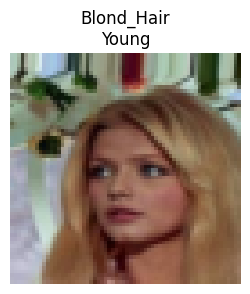

In [21]:
##Helpers to un-normalize and display image.

def unnormalize(img_tensor, mean = CELEBA_MEAN, std = CELEBA_STD):
    img = img_tensor.clone().detach().cpu()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(img, 0, 1) ## Converting back to (0,1) for display purposes.

img, attributes = test_data[0] ##Images and Attributes
attribute_names = test_data.attributes ##List of Attribute Names

##Showing first image and attributes.
attribs = [name for i, name in enumerate(attribute_names) if attributes[i] == 1] ##Checks if current attribute is active in image and will add to attribs variable.
plt.figure(figsize=(3,3))
plt.imshow(unnormalize(img).permute(1, 2, 0).numpy()) # Corrected imshow, numpy method, and dimension order
plt.title('\n'.join(attribs)); plt.axis('off')

##MODEL PREDICTION:
best_model.eval()
with torch.no_grad():
  logits = best_model(img.unsqueeze(0).to(device))
  probs = torch.sigmoid(logits).cpu().squeeze() > 0.5 ##Need to use this over softmax as we are dealing with multi-layer classification.
  preds = [name for i, name in enumerate(attribute_names) if probs[i]] # Corrected accessing attribute names and prediction logic

print ("True Attributes:", ", ".join(attribs)) # Corrected printing true attributes
print ("Predicted Attributes:", ", ".join(preds)) # Corrected printing predicted attributes

FINAL INTERPRETATIONS:

In the end, I implemented a mix of both the MobileNetV2 and ResNet structures. Similar to MobileNetV2, this uses inverted residual blocks. However, it replaces the depthwise separable convolutions with groupwise convolutions. In additon, it uses grouped residual bottleneck with expansion, which is then followed by grouped 3x3 convolutions. Because of the grouped convolutions, this is a useful model to use for multi-label classification and computer vision tasks. After some research, there are many other fields that use multi-label classification. For example, this model could be used in quality control fields. Since it is multi-label, it can help identify many differnt attributes in defective products. In addition, in the medical field, this could be used in relation to X-rays or MRIs as well, as it can distinguish multiple different aspects of a scan.